<a href="https://colab.research.google.com/github/lagonee23/price-prediction-models/blob/main/bitcoin_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 암호화폐(BitCoin)의 가격 예측 모델


### 필요 모듈 설치
> [pyupbit](https://github.com/sharebook-kr/pyupbit) 모듈은 업비트라는 암호화폐 거래소의 API를 파이썬에서 쉽게 사용하기 위해 개발되었습니다.
해당 라이브러리를 통해 암호화폐의 현재 가격, 매매 주문 등의 정보를 쉽게 얻어올 수 있습니다.

In [2]:
!pip install pyupbit
!pip3 install xgboost
!pip3 install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.3 MB/s eta 0:00:00


### 업비트에서 일봉(day)차트의 데이터 가져오기
* `open`: 시가
* `high`: 고가
* `low`: 저가
* `close`: 종가
* `volume`: 거래량
* `value`: 거래대금

> 업비트는 한국 거래소이므로 데이터의 단위는 원화(￦)입니다.

In [4]:
import pyupbit

# UpBit에서 비트코인 가격 데이터 가져오기
df_origin = pyupbit.get_ohlcv("KRW-BTC", "day", count=2500, period=1)
df_origin

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2023-12-03 09:00:00,52615000.0,53864000.0,52531000.0,53700000.0,3551.854502,1.884204e+11
2023-12-04 09:00:00,53761000.0,57337000.0,53690000.0,56920000.0,11395.027520,6.349280e+11
2023-12-05 09:00:00,56922000.0,60769000.0,56000000.0,60227000.0,9996.252712,5.807882e+11
2023-12-06 09:00:00,60230000.0,61312000.0,59572000.0,60314000.0,8840.709910,5.336398e+11


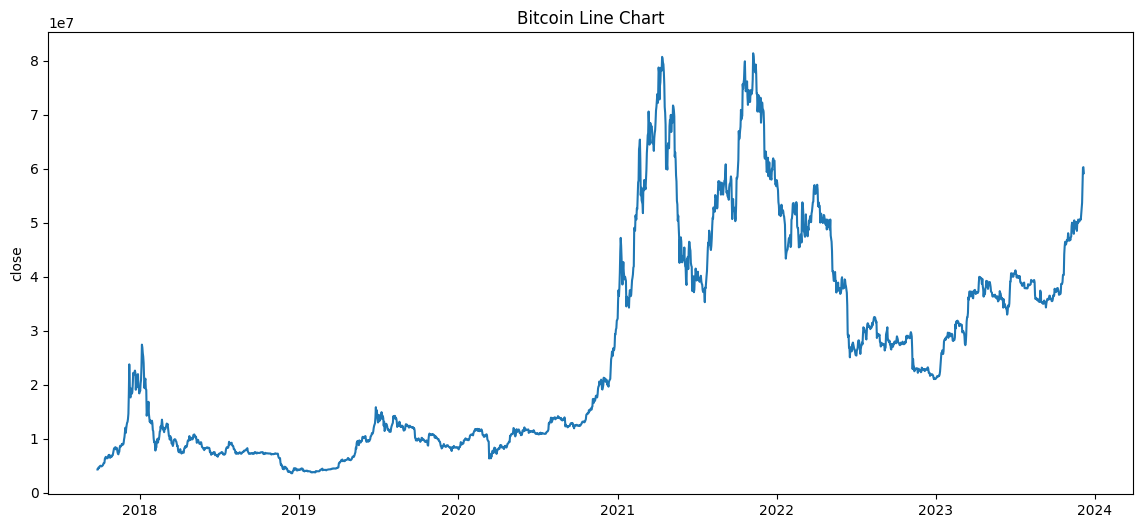

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_origin, x=df_origin.index, y='close')  # 비트코인 차트
plt.title('Bitcoin Line Chart');

## Model 1. Logistic Regression
---
> [로지스틱 회귀(logistic regression)](https://bluenoa.tistory.com/48)는 분류 문제를 해결하기 위한 강력한 통계 방법입니다. 종속 변수가 범주형 데이터(예: 이메일이 스팸인지 아닌지, 거래가 사기인지 아닌지 등)일 때 사용됩니다.

본 프로젝트에서는 가격이 몇 프로 올랐는지(혹은 내려갔는지), 거래량이 얼만큼 증감했는지에 따라 다음 날 가격 변화를 예측하려 합니다.

다음 날 가격이 올랐다면 `1`, 가격이 내려갔다면 `0`으로 표기합니다.

### 1-1. Feature engineering & EDA
* 새로운 컬럼을 생성
  * `candle`: 가격 변화율(%)
  * `volume_change_rate`: 거래량의 변화율(%)
  * `profit_loss`: 다음 날의 손실(0)과 이득(1)을 나타내는 컬럼을 생성

In [23]:
import numpy as np

# 원본 복사
df = df_origin.copy()

df['candle'] = ((df['close'] - df['open']) / df['open'] * 100).round(2)  # 가격 변화율 열 추가
df['volume_change_rate'] = (df['volume'].pct_change() * 100).round(2)  # 거래량 변화율 열 추가
df['profit_loss'] = np.where(df['close'].shift(-1) > df['open'].shift(-1), 1, 0)  # profit_loss 열 추가

# 첫 행과 마지막 행 삭제
df.drop([df.index[0], df.index[-1]], inplace=True)
# 불필요한 컬럼 삭제
df.drop(["open", "high", "low", "close", "volume", "value"], axis=1, inplace=True)

print(df.shape)
df.head()

(2263, 3)


,candle,volume_change_rate,profit_loss
2017-09-26 09:00:00,0.09,-82.80,1
2017-09-27 09:00:00,7.75,41.61,0
2017-09-28 09:00:00,-1.52,149.73,1
2017-09-29 09:00:00,1.55,-26.35,1
2017-09-30 09:00:00,5.11,-66.31,1


분류 문제는 항상 먼저 타겟의 범주가 어떤 비율을 가지고 있는지 확인해 보아야 합니다.

타겟 범주의 분포가 균형을 이루지 않고 한쪽으로 치우친 경우, 머신러닝 모델은 다수의 범주에 치우쳐 학습할 가능성이 높습니다. 이러한 상황에서는 소수의 범주에 대한 예측 성능이 저하될 수 있습니다.

타겟 데이터의 비율:
 1    0.517897
0    0.482103
Name: profit_loss, dtype: float64


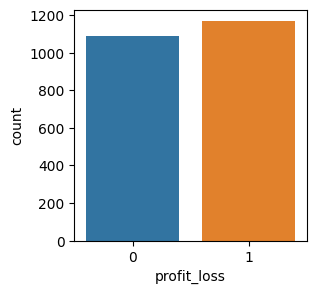

In [35]:
# 타겟 데이터 범주의 비율을 확인합니다.
y =  df['profit_loss']
print("타겟 데이터의 비율:\n", y.value_counts(normalize=True))

plt.figure(figsize=(3, 3))
sns.countplot(x=y);

### 1-2. Modeling

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

# 데이터를 몇개의 파트로 분할했는지 알 수 있습니다.
print('k =',kf.get_n_splits())

# split을 하면 데이터를 k번 k개로 분할합니다.
# 5번 학습을 진행하고 결과를 저장해 보겠습니다.

cv_result = []
for train_idx, test_idx in kf.split(X_train) :
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # 위에서 선언한 linear regression
    model.fit(X_train_cv, y_train_cv)

    # 모델 예측
    y_pred_cv = model.predict(X_val_cv)

    # mae를 구해보겠습니다.
    mae_cv = mean_absolute_error(y_val_cv, y_pred_cv).round(2)
    cv_result.append(mae_cv)

print('mae for each fold : ', cv_result)
print('average mae for model : ', np.mean(cv_result).round(2))
print('std of result : ', np.std(cv_result).round(2))

In [ ]:
# k-fold cross validation; k = 5
from sklearn.model_selection import cross_val_score

cv_results = cross_val_score(
    model,
    X_train_cv,
    y_train_cv,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
    )


print('mae for each fold : ', -np.round(cv_results, 2))
print('average mae for model : ', -np.mean(cv_results).round(2))
print('std of result : ', np.std(cv_results).round(2))

In [ ]:
# train, validation, test set으로 먼저 나눠주겠습니다.

from sklearn.model_selection import train_test_split

# 타겟값이 문자형이기 때문에 수치형으로 바꿔주겠습니다.
df['HeartDisease'] = df['HeartDisease'].replace({'No':0, 'Yes':1})

y = df['HeartDisease']
X = df.drop('HeartDisease', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, stratify=y_train)

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

### 기준모델 설정
**기준 모델(Baseline Model)**은 예측 문제를 해결하기 위해 설정하는 단순한 모델이나 기준을 의미합니다. 이 모델은 일반적으로 복잡한 머신러닝 모델을 사용하기 전에, 문제를 얼마나 잘 이해하고 있는지, 어떤 방식으로 접근해야하는지를 판단하는 데 도움을 줍니다.

본 프로젝트에서는 타겟 변수의 **평균값**으로 기준모델을 설정합니다.



In [9]:
import numpy as np

df = df_origin.copy()  # 원본복사

predict = df['close'].mean()  # 평균값
print('Baseline model:', np.around(predict))

Baseline model: 25930249.0


### 특성과 타겟을 분리, 학습과 테스트 데이터를 분리

In [10]:
from sklearn.model_selection import train_test_split

features = ['candle',	'volume_ratio']
target = 'profit_loss'

X, y = df[features], df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

KeyError: ignored

### 데이터 정규화 및 기준모델의 정확도 계산

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Scaling
scaler_std = StandardScaler()

X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)


# 기준모델
base = y_train.mode()[0]
baseline = len(y_train) * [base]
y_pred_base = len(y_test) * [base]
# 기준모델의 정확도
print("Train accuracy:", accuracy_score(y_train, baseline).round(3))
print("Test accuracy:", accuracy_score(y_test, y_pred_base).round(3))

### 기준모델의 Confusion Matrix

In [ ]:
y_true0 = y_test.value_counts()[0]
y_true1 = y_test.value_counts()[1]
confusion_base = pd.DataFrame(index = ['True 0', 'True 1'], data = {'Predicted 0':[0,0], 'Predicted 1':[y_true0,y_true1]})
confusion_base

### 모델의 정확도

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

# 로지스틱 회귀
logCV_model = LogisticRegressionCV(cv=5)
logCV_model.fit(X_train_std, y_train)

# 로지스틱 회귀모델의 정확도
print("Train accuracy:", logCV_model.score(X_train_std, y_train).round(3))

### 평가지표

In [ ]:
from sklearn.metrics import classification_report

y_pred_test_log = logCV_model.predict(X_test_std)

print(classification_report(y_test, y_pred_test_log))

## 랜덤포레스트 모델

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(oob_score=True, n_jobs=-1)
rf_model.fit(X_train, y_train)

print("Train accuracy:", rf_model.score(X_train, y_train).round(3))
print("Out-of-bag 샘플의 정확도:", rf_model.oob_score_.round(3))

In [ ]:
y_pred_test_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_test_rf))

## XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    eval_metric="error",
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    learning_rate=0.1,
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train)

# 정확도
print("Traing accuracy", xgb_model.score(X_train, y_train).round(3))

y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))